In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import optuna
import json

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score
)

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns




# Target

In [29]:
def get_target(input_df, ticker):
    df = input_df.copy()
    df["Target"] = (df[f"Close_{ticker}"].shift(-1) > df[f"Close_{ticker}"]).astype(int)
    df.dropna(inplace=True)
    return df

# Target TBM ( Triple Barrier Method)

In [30]:
def get_tbm_target(df, ticker, horizon=5, pt_sl=[1.5,1]):
    df = df.copy()
    close = df[f'Close_{ticker}']
    
    log_ret = np.log(close / close.shift(1))
    volatility = log_ret.rolling(window=20).std()
    
    targets = pd.Series(index=df.index, dtype=float)
    
    for i in range(len(df) - horizon):
        price_start = close.iloc[i]
        current_vol = volatility.iloc[i] ### dynamic barrier for each day
        
        upper_barrier = price_start * (1 + current_vol * pt_sl[0])
        lower_barrier = price_start * (1 - current_vol * pt_sl[1])
        
        future_prices = close.iloc[i+1 : i+ 1 + horizon]
        
        targets.iloc[i] = 0
        
        for price_future in future_prices:
            if price_future >= upper_barrier:
                targets.iloc[i] = 1 # profit taking hit
                break
            elif price_future <= lower_barrier:
                targets.iloc[i] = -1 # stop loss hit
                break
    df['Target'] = targets
    return df.dropna(subset=['Target'])

# Model: Ensemble (Voting Soft)
### With optuna to optimized

In [31]:
def build_ensemble_model(X_train, y_train):
    def objective(trial):
        # for Random Forest
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 50, 200)
        rf_max_depth = trial.suggest_int("rf_max_depth", 3, 10)
        
        # for XGBoost
        xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 0.01, 0.2, log=True)
        xgb_max_depth = trial.suggest_int("xgb_max_depth", 2, 6)
        
        # for SVM
        svm_c = trial.suggest_float("svm_c", 0.1, 10.0, log=True)
        
        lr_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial' ,random_state=42))
    ])
        rf_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("rf", RandomForestClassifier(
            n_estimators= rf_n_estimators,
            max_depth= rf_max_depth,
            min_samples_leaf=10,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ))
    ])  
        svm_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(
            kernel="rbf",
            C=svm_c,
            gamma="scale",
            class_weight='balanced',
            probability=True,
            random_state=42
        ))
    ])
        
        xgb_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("xgb", XGBClassifier(
            n_estimators=100,
            max_depth= xgb_max_depth,
            learning_rate= xgb_learning_rate,
            random_state=42,
            n_jobs=-1,
            eval_metric="logloss"
        ))
    ])
        
        ensemble = VotingClassifier(
            estimators= [('lr', lr_pipe),('rf', rf_pipe), ('svm', svm_pipe), ('xgb', xgb_pipe)],
            voting='soft'
        )
        
        tscv = TimeSeriesSplit(n_splits=3)
        score = cross_val_score(ensemble, X_train, y_train, cv=tscv, scoring='accuracy')
        
        return score.mean()
    
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=15)
        
    best = study.best_params    
    lr_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial' ,random_state=42))
    ])

    rf_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("rf", RandomForestClassifier(
            n_estimators=best['rf_n_estimators'],
            max_depth=best['rf_max_depth'],
            min_samples_leaf=10,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ))
    ])

    svm_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(
            kernel="rbf",
            C=best['svm_c'],
            gamma="scale",
            class_weight='balanced',
            probability=True,
            random_state=42
        ))
    ])

    xgb_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("xgb", XGBClassifier(
            n_estimators=100,
            max_depth=best['xgb_max_depth'],
            learning_rate=best['xgb_learning_rate'],
            random_state=42,
            n_jobs=-1,
            eval_metric="logloss"
        ))
    ])

    model = VotingClassifier(
        estimators=[
            ("lr", lr_pipeline),
            ("rf", rf_pipeline),
            ("svm", svm_pipeline),
            ("xgb", xgb_pipeline),
        ],
        voting="soft"
    )
    return model

### Sample Weights

In [32]:
    def get_sample_weights(df, ticker, horizon=5):
        # create a binary matrix indicating which days are covered by which barrier
        num_rows = len(df)
        concurrency = np.zeros(num_rows)

        for i in range(num_rows - horizon):
            concurrency[i  : i + horizon] += 1

        uniqueness = 1.0 / np.maximum(concurrency, 1)

        weights = pd.Series(index=df.index, dtype=float)
        for i in range(num_rows - horizon):
            weights.iloc[i] = uniqueness[i : i + horizon].mean()
        
        return weights.fillna(0)

# Walk Forward validation with purging and embargo in validation


In [33]:
def walk_forward_validation_with_purging(
    df,
    features,
    target_col="Target",
    date_col="DATE",
    start_year=2010,
    first_train_end_year=2015,
    last_test_year=2023,
    horizon = 5,
    embargo_pct = 0.01
):
    """
    Train: start_year -> train_end_year
    Test : train_end_year+1
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)

    all_y_true = []
    all_y_pred = []
    all_y_proba = []

    fold_rows = []

    sample_weights_all = get_sample_weights(df, horizon)
    
    for train_end_year in range(first_train_end_year, last_test_year):
        test_year = train_end_year + 1

        train_mask = (df[date_col].dt.year >= start_year) & (df[date_col].dt.year <= train_end_year)
        test_mask = (df[date_col].dt.year == test_year)

        train_df = df[train_mask]
        test_df = df[test_mask]

        # jeżeli jakiś rok nie ma danych to skip
        if len(train_df) < 200 or len(test_df) < 50:
            continue

        ## Purging
        train_df_purged = train_df.iloc[:-horizon]
        weights_train = sample_weights_all.loc[train_df_purged.index] 
        
        ## Embargo
        embargo_size = int(len(df) * embargo_pct)
        test_df_embargo = test_df.iloc[embargo_size:]
        
        if len(test_df_embargo) < 10: continue
        
        
        X_train = train_df_purged[features]
        y_train = train_df_purged[target_col]

        X_test = test_df_embargo[features]
        y_test = test_df_embargo[target_col]

        model = build_ensemble_model(X_train,  y_train)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test) 

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        auc = roc_auc_score(y_test, y_proba, average='weighted', multi_class='ovr')

        fold_rows.append({
            "train_end_year": train_end_year,
            "test_year": test_year,
            "n_train": len(train_df),
            "n_test": len(test_df),
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "roc_auc": auc
        })

        all_y_true.extend(y_test.tolist())
        all_y_pred.extend(y_pred.tolist())
        all_y_proba.extend(y_proba.tolist())

    folds_df = pd.DataFrame(fold_rows)

    return folds_df, np.array(all_y_true), np.array(all_y_pred), np.array(all_y_proba)




# Block bootstrap

In [34]:
def block_bootstrap_accuracy(y_true, y_pred, block_size=20, n_bootstrap=1000, random_state=42):
    """
    Bootstrap na wynikach testowych (y_true/y_pred), losowanie blokami.
    """
    rng = np.random.default_rng(random_state)
    n = len(y_true)

    if n < block_size:
        raise ValueError("Za mało danych do bootstrapa w tej konfiguracji.")

    acc_samples = []

    for _ in range(n_bootstrap):
        sampled_idx = []

        while len(sampled_idx) < n:
            start = rng.integers(0, n - block_size + 1)
            block = list(range(start, start + block_size))
            sampled_idx.extend(block)

        sampled_idx = sampled_idx[:n]
        y_true_bs = y_true[sampled_idx]
        y_pred_bs = y_pred[sampled_idx]

        acc = accuracy_score(y_true_bs, y_pred_bs)
        acc_samples.append(acc)

    acc_samples = np.array(acc_samples)
    ci_low = np.percentile(acc_samples, 2.5)
    ci_high = np.percentile(acc_samples, 97.5)

    return acc_samples, ci_low, ci_high



# Walk_forward + Bootstrap

In [35]:


def run_stage4_for_ticker(df_raw, ticker, selected_features):
    df = get_tbm_target(df_raw, ticker)

    selected_features = [f for f in selected_features if f in df.columns]

    folds_df, y_true_all, y_pred_all, y_proba_all = walk_forward_validation_with_purging(
        df=df,
        features=selected_features,
        target_col="Target",
        date_col="DATE",
        start_year=2010,
        first_train_end_year=2015,
        last_test_year=2023 
    )

    print("=" * 60)
    print(f" WALK-FORWARD RESULTS for {ticker}")
    metrics = ["accuracy", "precision", "recall", "roc_auc"]
    summary_mean = folds_df[metrics].mean()

    print("\n--- Summary ---")
    print(summary_mean.to_frame(name="Mean").T)
     
    print("\n--- Detailed Classification Report (Whole Period) ---")    
    print(classification_report(y_true_all, y_pred_all, zero_division=0))
    
    # Block Bootstrap
    acc_samples, ci_low, ci_high = block_bootstrap_accuracy(
        y_true=y_true_all,
        y_pred=y_pred_all,
        block_size=20,
        n_bootstrap=1000
    )

    print("\n" + "=" * 60)
    print(f" BLOCK BOOTSTRAP for {ticker}")
    print(f"95% CI accuracy: [{ci_low:.4f}, {ci_high:.4f}]")
    print(f"Bootstrap mean accuracy: {acc_samples.mean():.4f}")

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true_all, y_pred_all)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Loss (-1)', 'Neutral (0)', 'Profit (1)'],
                yticklabels=['Loss (-1)', 'Neutral (0)', 'Profit (1)'])
    plt.title(f'Confusion Matrix for {ticker}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return folds_df, acc_samples


# Example use

------AAPL-----
Selected features for AAPL:
Running for AAPL with selected features (15)


[I 2026-01-25 14:59:16,805] A new study created in memory with name: no-name-6c086a25-f43d-4afb-878d-cd6f50248a0b
[I 2026-01-25 14:59:18,077] Trial 0 finished with value: 0.38917089678511 and parameters: {'rf_n_estimators': 154, 'rf_max_depth': 9, 'xgb_learning_rate': 0.024515493070551606, 'xgb_max_depth': 2, 'svm_c': 1.5668762231885158}. Best is trial 0 with value: 0.38917089678511.
[I 2026-01-25 14:59:19,014] Trial 1 finished with value: 0.377326565143824 and parameters: {'rf_n_estimators': 133, 'rf_max_depth': 5, 'xgb_learning_rate': 0.12534284897939485, 'xgb_max_depth': 3, 'svm_c': 0.49888536133814493}. Best is trial 0 with value: 0.38917089678511.
[I 2026-01-25 14:59:20,281] Trial 2 finished with value: 0.3688663282571912 and parameters: {'rf_n_estimators': 118, 'rf_max_depth': 3, 'xgb_learning_rate': 0.1468283832626506, 'xgb_max_depth': 6, 'svm_c': 0.222977952934392}. Best is trial 0 with value: 0.38917089678511.
[I 2026-01-25 14:59:21,439] Trial 3 finished with value: 0.38917089

 WALK-FORWARD RESULTS for AAPL

--- Summary ---
      accuracy  precision    recall   roc_auc
Mean  0.384323   0.300725  0.384323  0.568891

--- Detailed Classification Report (Whole Period) ---
              precision    recall  f1-score   support

        -1.0       0.37      0.45      0.41       657
         0.0       0.28      0.14      0.18       405
         1.0       0.42      0.47      0.44       686

    accuracy                           0.38      1748
   macro avg       0.36      0.35      0.35      1748
weighted avg       0.37      0.38      0.37      1748


 BLOCK BOOTSTRAP for AAPL
95% CI accuracy: [0.3415, 0.4222]
Bootstrap mean accuracy: 0.3836


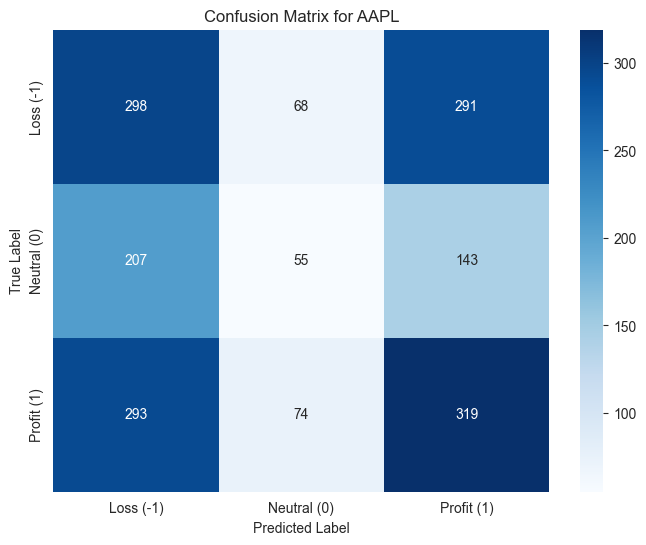

------GOOGL-----
Selected features for GOOGL:
Running for GOOGL with selected features (47)


[I 2026-01-25 15:02:05,205] A new study created in memory with name: no-name-4ee4905f-0bf6-4b44-a698-49af94535f26
[I 2026-01-25 15:02:06,148] Trial 0 finished with value: 0.39424703891708973 and parameters: {'rf_n_estimators': 197, 'rf_max_depth': 9, 'xgb_learning_rate': 0.013780541939310196, 'xgb_max_depth': 2, 'svm_c': 0.9130232405886414}. Best is trial 0 with value: 0.39424703891708973.
[I 2026-01-25 15:02:07,561] Trial 1 finished with value: 0.3688663282571912 and parameters: {'rf_n_estimators': 108, 'rf_max_depth': 10, 'xgb_learning_rate': 0.01779317021320617, 'xgb_max_depth': 5, 'svm_c': 2.1663558860015693}. Best is trial 0 with value: 0.39424703891708973.
[I 2026-01-25 15:02:09,199] Trial 2 finished with value: 0.3705583756345178 and parameters: {'rf_n_estimators': 108, 'rf_max_depth': 8, 'xgb_learning_rate': 0.02428409042483983, 'xgb_max_depth': 6, 'svm_c': 0.6691849821829171}. Best is trial 0 with value: 0.39424703891708973.
[I 2026-01-25 15:02:10,059] Trial 3 finished with va

 WALK-FORWARD RESULTS for GOOGL

--- Summary ---
      accuracy  precision    recall   roc_auc
Mean  0.336251   0.399019  0.336251  0.592523

--- Detailed Classification Report (Whole Period) ---
              precision    recall  f1-score   support

        -1.0       0.35      0.47      0.40       678
         0.0       0.26      0.22      0.24       460
         1.0       0.37      0.27      0.31       610

    accuracy                           0.34      1748
   macro avg       0.33      0.32      0.32      1748
weighted avg       0.33      0.34      0.33      1748


 BLOCK BOOTSTRAP for GOOGL
95% CI accuracy: [0.3032, 0.3724]
Bootstrap mean accuracy: 0.3370


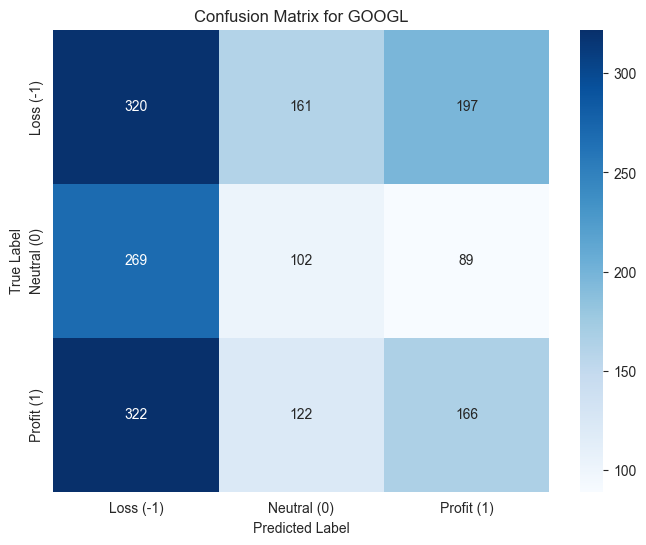

------MSFT-----
Selected features for MSFT:
Running for MSFT with selected features (15)


[I 2026-01-25 15:05:51,283] A new study created in memory with name: no-name-ec6a0a20-9675-4a37-a19e-9695a29fe738
[I 2026-01-25 15:05:52,459] Trial 0 finished with value: 0.4027072758037225 and parameters: {'rf_n_estimators': 146, 'rf_max_depth': 10, 'xgb_learning_rate': 0.033762608816740494, 'xgb_max_depth': 5, 'svm_c': 2.1819691077235994}. Best is trial 0 with value: 0.4027072758037225.
[I 2026-01-25 15:05:53,074] Trial 1 finished with value: 0.416243654822335 and parameters: {'rf_n_estimators': 68, 'rf_max_depth': 3, 'xgb_learning_rate': 0.1996978147300048, 'xgb_max_depth': 2, 'svm_c': 4.726637505077622}. Best is trial 1 with value: 0.416243654822335.
[I 2026-01-25 15:05:54,308] Trial 2 finished with value: 0.4077834179357022 and parameters: {'rf_n_estimators': 106, 'rf_max_depth': 6, 'xgb_learning_rate': 0.13661185154019248, 'xgb_max_depth': 6, 'svm_c': 1.8067193008142086}. Best is trial 1 with value: 0.416243654822335.
[I 2026-01-25 15:05:54,934] Trial 3 finished with value: 0.407

 WALK-FORWARD RESULTS for MSFT

--- Summary ---
      accuracy  precision    recall   roc_auc
Mean  0.353466   0.321648  0.353466  0.593318

--- Detailed Classification Report (Whole Period) ---
              precision    recall  f1-score   support

        -1.0       0.35      0.29      0.32       658
         0.0       0.33      0.34      0.34       461
         1.0       0.37      0.43      0.40       629

    accuracy                           0.35      1748
   macro avg       0.35      0.35      0.35      1748
weighted avg       0.35      0.35      0.35      1748


 BLOCK BOOTSTRAP for MSFT
95% CI accuracy: [0.3186, 0.3839]
Bootstrap mean accuracy: 0.3517


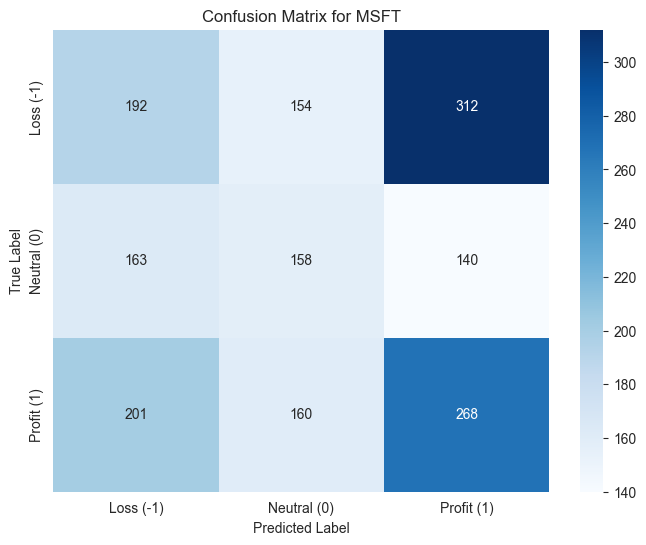

In [36]:

tickers = ["AAPL", "GOOGL", "MSFT"]

with open("../../models_results/feature_dict.json", "r") as f:
    feature_dict = json.load(f)


def get_all_features(df):
    return [c for c in df.columns if c not in ["DATE", "index", "Target"]]

for share in tickers:
    data = pd.read_csv(f"../../data/all_data/all_{share}_data.csv")
    df_tmp = get_tbm_target(data, share)
    features_aapl = get_all_features(df_tmp)
    print(f"------{share}-----")
        
    selected_features = feature_dict[share]
    print(f"Selected features for {share}:")
    # print(f"Running for {share} with all features ({len(features_aapl)})")
    # run_stage4_for_ticker(data, share, features_aapl)
    print(f"Running for {share} with selected features ({len(selected_features)})")
    run_stage4_for_ticker(data, share, selected_features)